# Solutions to Quantitive Analyst Technical Assessment

In this notebook we will answer the three questions from the technical assessment for the position as a Quantitative Analyst. We have decided to use a notebook because it provides nice visualization and reporting tools. 

First, let us import all the necessary modules that we are going to use throughout the questions.

In [144]:
import pandas as pd
import numpy as np
from numpy import NaN
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
%matplotlib inline

Before solving the questions we need to read the data from the Excel file, we do this using `pandas`. The choice of `pandas`makes sense in this context, since it offers a very easy way to read data from excel, as well as many statistical tools and the amount of data is not too large.

In [93]:
house_data = pd.read_excel("listings.xlsx")
house_data.head()

,id,address,municipality_name,municipality_ine_code,district_name,district_ine_code,asking_price,bedrooms,bathrooms,floor,publishing_date,surface,has_elevator
0,54-98643435,Barrio Palacio,Madrid,28079,Centro,2807901,1050,1,1,5.0,2022-08-27,47,1.0
1,54-90305455,"Urb. Calle Carretas, 3",Madrid,28079,Centro,2807901,3800,3,2,5.0,2020-07-21,136,1.0
2,54-485982,"Calle Mayor, 9",Madrid,28079,Centro,2807901,900,1,1,4.0,2019-07-30,50,1.0
3,54-98791494,"Calle de la Colegiata, 18",Madrid,28079,Centro,2807901,2300,4,2,4.0,2022-09-15,141,1.0
4,54-99021484,Calle de Tetuán,Madrid,28079,Centro,2807901,3300,4,3,4.0,2022-10-03,159,0.0


## Q.1

Using the provided data, study whether there is a statistically significant relationship between the asking price of a house and the following variables:
- Surface
- Has elevator
- Number of bedrooms
- Number of bathrooms
- Floor

We are going to base this statistical analysis in the correlation coefficient between the variables and the visual analysis of the data. As a first approach, let us compute the correlation coefficients of each of the variables with the asking price.

In [94]:
corrs = house_data[["surface", "has_elevator","bedrooms","bathrooms", "floor"]].corrwith(house_data["asking_price"])
corr_table = pd.DataFrame({"Variable": corrs.index, "Correlation":corrs.values})
HTML(corr_table.to_html(index=False))

Variable,Correlation
surface,0.292860
has_elevator,0.179654
bedrooms,0.521381
bathrooms,0.711628
floor,0.108273


At first glance, only the number of bedrooms and the number of bathrooms have a really significant correlation with the asking price. In the case of these two variables, the plot seems to confirm this relationship.

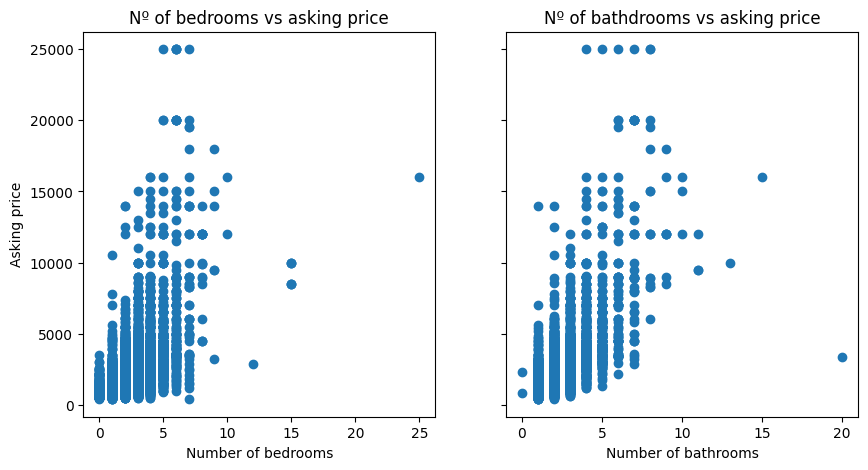

In [95]:
asking_price = house_data["asking_price"]
bedrooms = house_data["bedrooms"]
bathrooms = house_data["bathrooms"]

fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (10,5))
ax1.scatter(bedrooms, asking_price)
ax1.set_title("Nº of bedrooms vs asking price")
ax1.set_ylabel("Asking price")
ax1.set_xlabel("Number of bedrooms")
ax2.scatter(bathrooms, asking_price)
ax2.set_title("Nº of bathdrooms vs asking price")
ax2.set_xlabel("Number of bathrooms")
plt.show()

Let us have a look at other variables that we may expect to have higher correlation. For instance, it seems like the surface is impacting the price less that expected. In order to study what is happening, let us plot the the data.

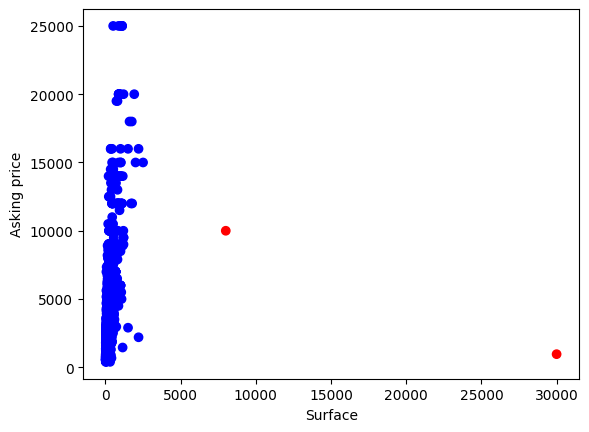

In [96]:
surface = house_data["surface"]
col = np.where(surface < 5000, 'b', 'r')
plt.scatter(surface, asking_price, c = col)
plt.xlabel("Surface")
plt.ylabel("Asking price")
plt.show()

We can see that there are some outliers that are affecting the correlation coefficient negatively, so let us recompute the correlation after dropping these outliers.

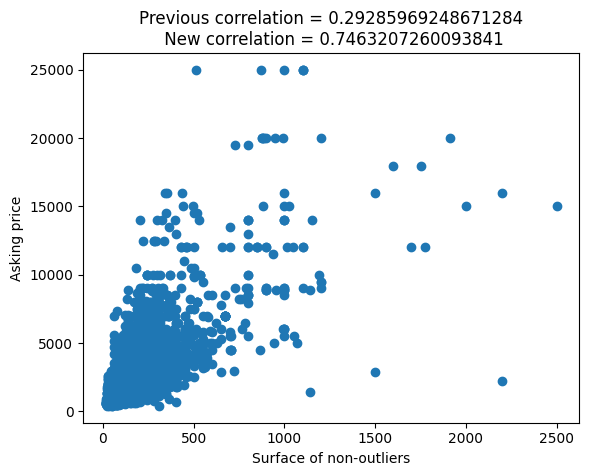

In [97]:
plt.scatter(surface[surface<5000], house_data[house_data["surface"]<5000]["asking_price"])
plt.xlabel("Surface of non-outliers")
plt.ylabel("Asking price")
surface_correlation = house_data[house_data["surface"]<5000][["surface","asking_price"]].corr().iloc[0,1]
plt.title(f"Previous correlation = {corr_table.iloc[0,1]}\n New correlation = {surface_correlation}")
plt.show()

We can now clearly see that there is indeed a statistically significant relationship between surface and asking price. 

Finally, we may expect the price of higher floors to vary according to having an elevator or not. We are going to see what happens with the correlation between floor and price provided that there is no elevator and provided that there is an elevator.

In [98]:
has_elevator = house_data[house_data["has_elevator"] == 1][["floor", "asking_price"]]
no_elevator = house_data[house_data["has_elevator"] == 0][["floor", "asking_price"]]
print(f"Overall correlation of floor and asking price: {corr_table.iloc[-1,1]}")
print(f"Correlation having elevator: {has_elevator.corr().iloc[1,0]}")
print(f"Correlation not having elevator: {no_elevator.corr().iloc[1,0]}")

Overall correlation of floor and asking price: 0.10827320218548293
Correlation having elevator: 0.06599463532808571
Correlation not having elevator: 0.00088029910772469


We observe that in both cases the correlation not only has not increased, but it has actually decreased. Specially in the case of not having an elevator. In this latter case it was expected to go down since we would expect the price of higher floors to decrease in absence of elevator. But still, we do not see a clear significant relationship. Let us look at the data to see what is happening.

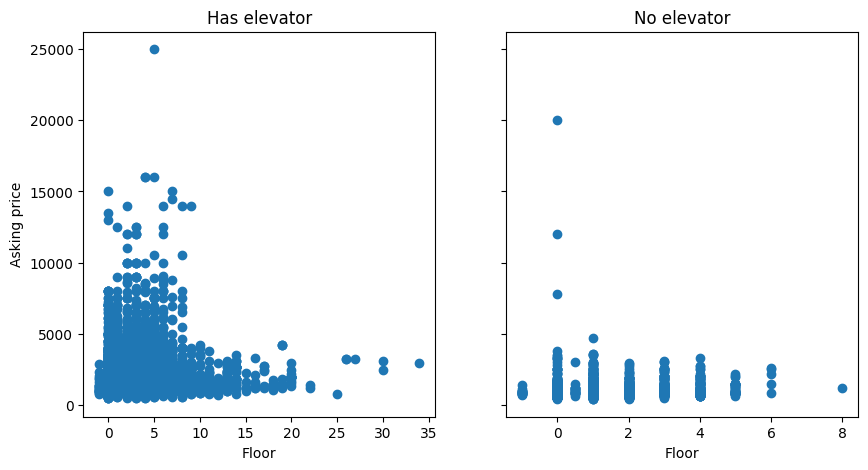

In [99]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (10,5))
ax1.scatter(has_elevator["floor"], has_elevator["asking_price"])
ax1.set_title("Has elevator")
ax1.set_ylabel("Asking price")
ax1.set_xlabel("Floor")
ax2.scatter(no_elevator["floor"], no_elevator["asking_price"])
ax2.set_title("No elevator")
ax2.set_xlabel("Floor")
plt.show()

We can observe a few things from the plot. First of all, we can see that there are a lot less houses without elevators, and those are concentrated in lower floors. This means that very high floors without elevators are normally not found in the market. This makes sense and is the main reason why we do not see a significantly negative correlation between the floor and the price when there is no elevator. Maybe we could see this effect with more data.

In the case when there is elevator, the floor becomes less important since access is easier. So in general, for lower floors there are other factors that have a greater impact in the price. It may be relevant to notice as well that when an elevator is present, higher floors start to increase in price. Probably, due to the good views and absence of street noises. This can be seen in the following plot.

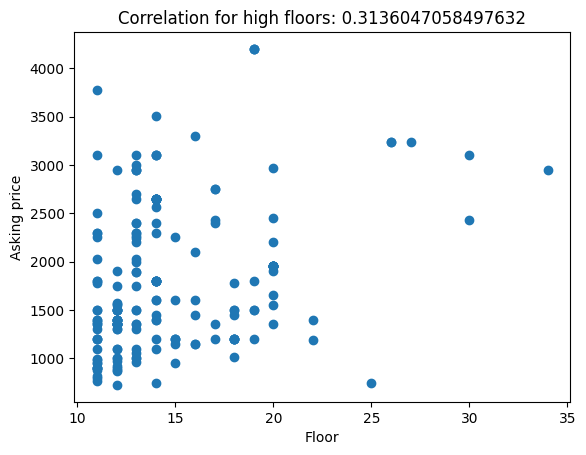

In [100]:
high_floor_with_elevator = house_data[(house_data["has_elevator"] == 1) & (house_data["floor"] > 10)][["floor", "asking_price"]]
plt.scatter(high_floor_with_elevator["floor"], high_floor_with_elevator["asking_price"])
plt.title(f"Correlation for high floors: {high_floor_with_elevator.corr().iloc[1,0]}")
plt.ylabel("Asking price")
plt.xlabel("Floor")
plt.show()

## Q. 2

Using the data:
1. Compute the mean and median amount of time that a house remains published. Assume that all houses were rented on 31/12/2022.
2. Is there any significant difference between the above mean time and the mean time of the district of Villaverde?
3. Is there a feature in this district that (*ceteris paribus*) produces a decrease in the time a house remains published on the market?

### Q. 2.1

We compute the number of days between the publishing date the rent date. Then we compute the mean and median.

In [118]:
rent_date = pd.to_datetime("2022-12-31", format = "%Y-%m-%d")
days_published = rent_date - house_data["publishing_date"]
mean_days = days_published.mean().days
median_days = days_published.median().days

print("Amount of time a house remains published.")
print(f"Mean: {mean_days} days")
print(f"Median: {median_days} days")

Amount of time a house remains published.
Mean: 362 days
Median: 112 days


We observe that the mean is considerably greater than the median. This is normal since the distribution is naturally skewed to the right, as the minimum amount of days is 0, while the distribution is not bounded on the right. This can be seen better in the following density plot.

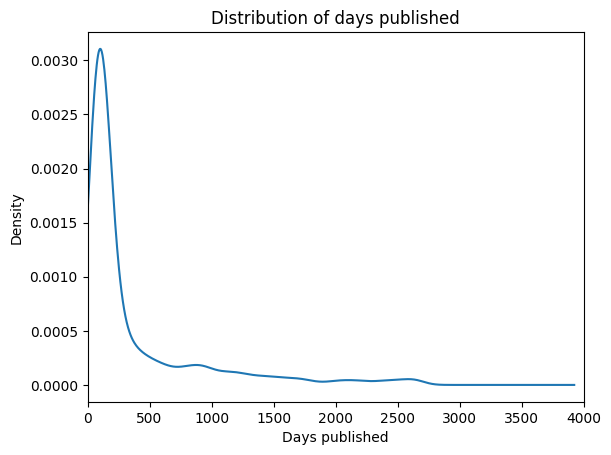

In [102]:
days_published.apply(lambda x: x.days).plot.density()
plt.xlim([0,4000])
plt.title("Distribution of days published")
plt.xlabel("Days published")
plt.show()

### Q. 2.2

We compute the mean amount of days for the district of Villaverde and compare it with the overall mean.

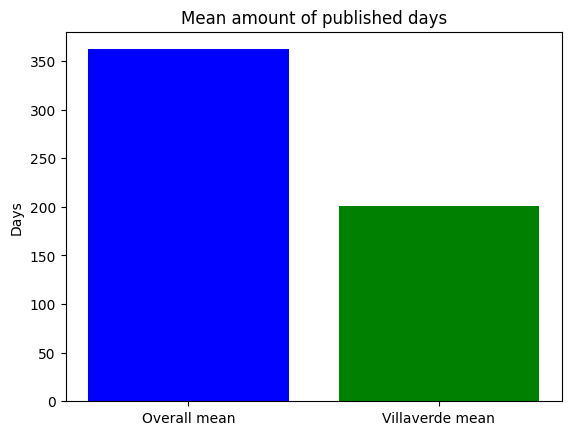

Mean days for Villaverde: 201 days.
Mean overall days: 362 days
Difference: 161 days
Difference in std: 0.30377358490566037


In [103]:
villaverde_publishing_dates = house_data[house_data["district_name"] == "Villaverde"]["publishing_date"]
villaverde_publishing_time = rent_date - villaverde_publishing_dates 
mean_villaverde_days = villaverde_publishing_time.mean().days
std = days_published.std().days
diff = mean_days-mean_villaverde_days
plt.bar(["Overall mean", "Villaverde mean"], [mean_days, mean_villaverde_days], color = ("b", "g"))
plt.title("Mean amount of published days")
plt.ylabel("Days")
plt.show()

print(f"Mean days for Villaverde: {mean_villaverde_days} days.")
print(f"Mean overall days: {mean_days} days")
print(f"Difference: {diff} days")
print(f"Difference in std: {diff/std}")


We observe that there is a significant difference between the mean time for Villaverde and the overall mean time.

### Q. 2.3

For this question we split the dataset into Villaverde and non Villaverde data, and look at the main features that influence the price according to Q. 1. 

In [249]:
villaverde_data = house_data[house_data["district_name"] == "Villaverde"][["surface", "bedrooms", "bathrooms", "asking_price"]]
villaverde_means = villaverde_data.mean()

non_villaverde_data = house_data[house_data["district_name"] != "Villaverde"][["surface", "bedrooms", "bathrooms", "asking_price"]]
non_villaverde_means = non_villaverde_data.mean()

comparison = pd.DataFrame({"Feature":villaverde_means.index, "Villaverde mean": villaverde_means, "Non Villaverde mean": non_villaverde_means})
HTML(comparison.to_html(index=False))

Feature,Villaverde mean,Non Villaverde mean
surface,69.432203,124.256854
bedrooms,2.372881,2.351610
bathrooms,1.144068,1.842134
asking_price,850.110169,1942.843790


From the table above we can see that the average price in Villaverde is much lower than the average of other districts, causing the houses in Villaverde to be rented earlier. However, there is a remarkable difference in the average surface and number of bathrooms per house, so we will take this into account in the analysis to make the difference between districts more clear. For the sake of completeness we will also compute the average price per bedroom, but it is clear that this is much lower in Villaverde since the average amount of bedrooms is similar to the other districts.

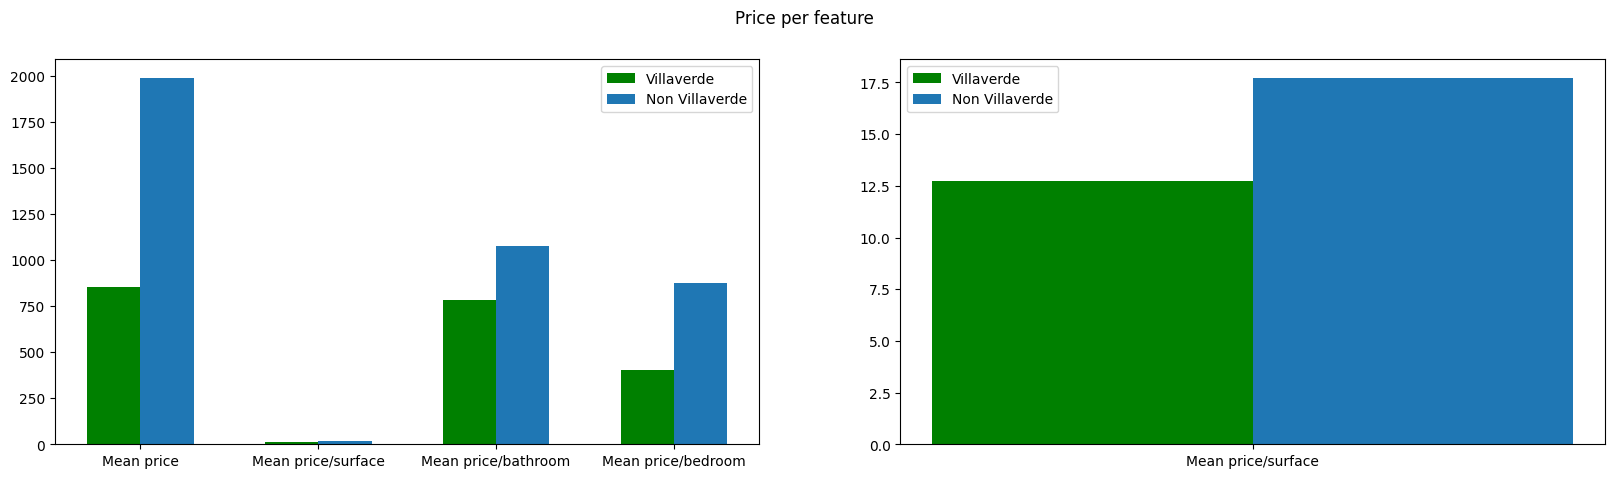

In [105]:
villaverde_data["price_per_surface"] = villaverde_data["asking_price"]/villaverde_data["surface"]
non_villaverde_data["price_per_surface"] =  non_villaverde_data["asking_price"]/non_villaverde_data["surface"]

villaverde_data["price_per_bathroom"] = villaverde_data["asking_price"]/villaverde_data["bathrooms"]
non_villaverde_data["price_per_bathroom"] =  non_villaverde_data["asking_price"]/non_villaverde_data["bathrooms"]

villaverde_data["price_per_bedroom"] = villaverde_data["asking_price"]/villaverde_data["bedrooms"]
non_villaverde_data["price_per_bedroom"] =  non_villaverde_data["asking_price"]/non_villaverde_data["bedrooms"]

villaverde_data = villaverde_data.replace(np.inf, NaN).dropna()
non_villaverde_data = non_villaverde_data.replace(np.inf, NaN).dropna()


villaverde_mean_price = villaverde_data["asking_price"].mean()
non_villaverde_mean_price = non_villaverde_data["asking_price"].mean()

villaverde_mean_price_per_surface = villaverde_data["price_per_surface"].mean()
non_villaverde_mean_price_per_surface = non_villaverde_data["price_per_surface"].mean()

villaverde_mean_price_per_bath = villaverde_data["price_per_bathroom"].mean()
non_villaverde_mean_price_per_bath = non_villaverde_data["price_per_bathroom"].mean()

villaverde_mean_price_per_bed = villaverde_data["price_per_bedroom"].mean()
non_villaverde_mean_price_per_bed = non_villaverde_data["price_per_bedroom"].mean()

villaverde_features = [villaverde_mean_price, villaverde_mean_price_per_surface, villaverde_mean_price_per_bath, villaverde_mean_price_per_bed]
non_villaverde_features = [non_villaverde_mean_price, non_villaverde_mean_price_per_surface, non_villaverde_mean_price_per_bath, non_villaverde_mean_price_per_bed]

labels = ["Mean price", "Mean price/surface", "Mean price/bathroom", "Mean price/bedroom"]
width = 0.3
xaxis = np.arange(0,4)
fig, ax = plt.subplots(1,2, figsize = (20,5))
fig.suptitle("Price per feature")
ax[0].bar(xaxis, villaverde_features, color = "g", width=width, label="Villaverde")
ax[0].bar(xaxis+width, non_villaverde_features, width=width, label = "Non Villaverde")
ax[0].set_xticks(xaxis + width/2,labels)
ax[1].bar([0], villaverde_mean_price_per_surface, width=width, color = "g", label = "Villaverde")
ax[1].bar([width], non_villaverde_mean_price_per_surface, width=width, label = "Non Villaverde")
ax[1].set_xticks([width/2], ["Mean price/surface"])
ax[0].legend()
ax[1].legend()
plt.show()

The above bar chart shows that all prices per feature in Villaverde are significantly lower. We have plotted the price per surface in a different chart to make it more clearly visible.

## Q. 3

Using the data and possibly external sources, segment the municipalities of the province of Madrid (with more than 30 houses) in heterogeneous groups. The groups should be homogeneous in terms of price and time in the market.

Visualize the data to make it easily understandable for all sorts of users.

For this exercise we are going to first add a column with the amount of days in the market. Then we will filter the municipalities that have more than 30 houses in the market. Next, we will compute the mean price and time on the market of each municipality. Then we will apply a the k-means clustering algorithm to make the groups. To determine k we will use seveal heuristic and visual techniques.

In [140]:
house_data["days_published"] = days_published.apply(lambda x: x.days)
more_than_30_houses = house_data["municipality_name"].value_counts().gt(30)
chosen_municipalities = house_data["municipality_name"].value_counts().index[more_than_30_houses]
filtered_data = house_data[house_data["municipality_name"].isin(chosen_municipalities)]
grouped_data = filtered_data.groupby("municipality_name")[["asking_price", "days_published"]].mean()
grouped_data.columns = ["Mean_price", "Mean_market_time"]
grouped_data

,Mean_price,Mean_market_time
municipality_name,,
Alcalá de Henares,870.933824,286.014706
Alcobendas,4733.483395,468.206642
Alcorcón,951.090909,280.309091
Algete,2221.268293,260.829268
Aranjuez,771.145833,415.104167
Boadilla del Monte,2651.301370,315.232877
Collado Villalba,968.586957,304.869565
Colmenar Viejo,1015.694444,422.500000
Galapagar,1025.285714,264.714286


For the purpose of clustering we will normalize the data do that price and time both range in the interval [0,1]. This will make both parameters equally heavy in terms of measuring distance between municipalities.

In [141]:
normalized_data = (grouped_data - grouped_data.min())/(grouped_data.max()-grouped_data.min())
normalized_data

,Mean_price,Mean_market_time
municipality_name,,
Alcalá de Henares,0.025184,0.379681
Alcobendas,1.000000,1.000000
Alcorcón,0.045414,0.360254
Algete,0.365977,0.293930
Aranjuez,0.000000,0.819199
Boadilla del Monte,0.474507,0.479161
Collado Villalba,0.049829,0.443877
Colmenar Viejo,0.061718,0.844380
Galapagar,0.064139,0.307158


We know apply the k-means algorithm to the above data. However, it is good to plot the data before applying any algorithm to have an idea of what the results should look like.

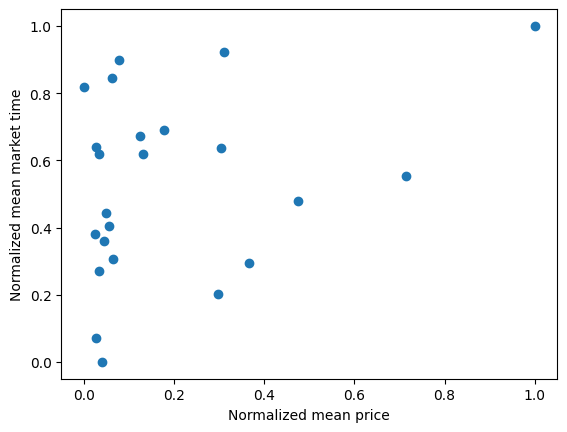

In [147]:
x = normalized_data["Mean_price"]
y = normalized_data["Mean_market_time"]
plt.scatter(x = normalized_data["Mean_price"], y = normalized_data["Mean_market_time"])
plt.xlabel("Normalized mean price")
plt.ylabel("Normalized mean market time")
plt.show()

We apply the k-means algorithm for several values of k, and use the elbow method to find a good value of k.

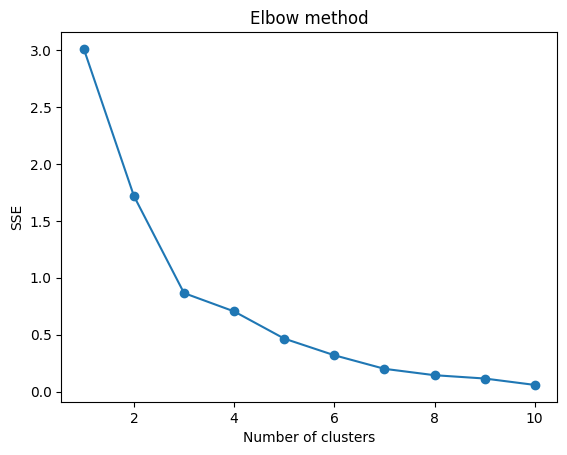

In [151]:
data = list(zip(normalized_data["Mean_price"],normalized_data["Mean_market_time"]))
sse = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init = 'auto')
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

plt.plot(range(1,11), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

The elbow plot seems to suggest a value of $k=3$, but it is not completely obvious. Let us use an automatic method to identify the elbow.

In [153]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)
kl.elbow

3

This method also suggest 3 clusters. Let us have a look at the resulting clustering for $k=3$.

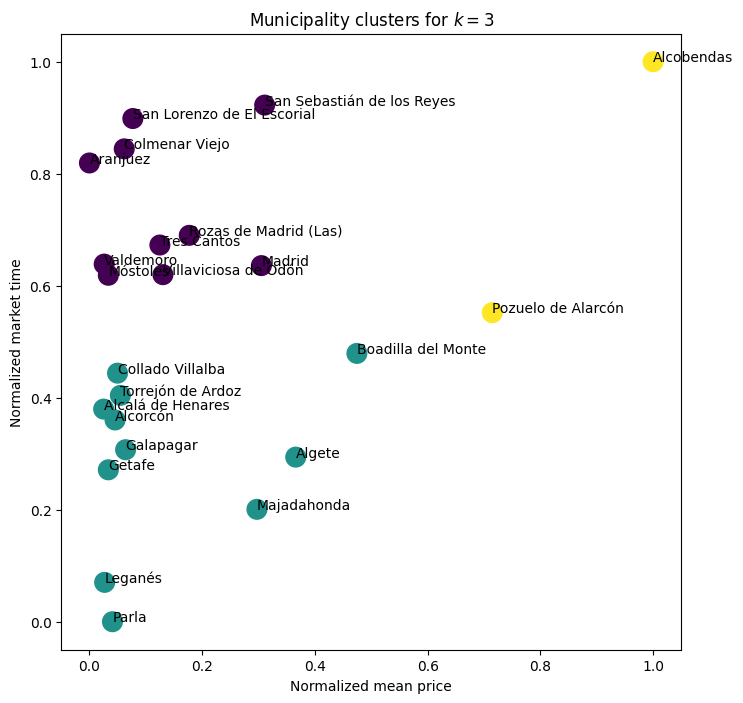

In [159]:
kmeans = KMeans(n_clusters=3, n_init="auto")
kmeans.fit(data)
x = normalized_data["Mean_price"]
y = normalized_data["Mean_market_time"]
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(x, y, c=kmeans.labels_,s=200)
ax.set_xlabel("Normalized mean price")
ax.set_ylabel("Normalized market time")
ax.set_title("Municipality clusters for $k=3$")
for i,text in enumerate(normalized_data.index):
  ax.annotate(text, (x[i], y[i]))

plt.show()

According to the plot, it seems like we could benefit from a few more groups, since the algorithm is grouping relatively distant municipalities. In order to have a better approximation to the number of clusters, we are going to use the silhoutte method.

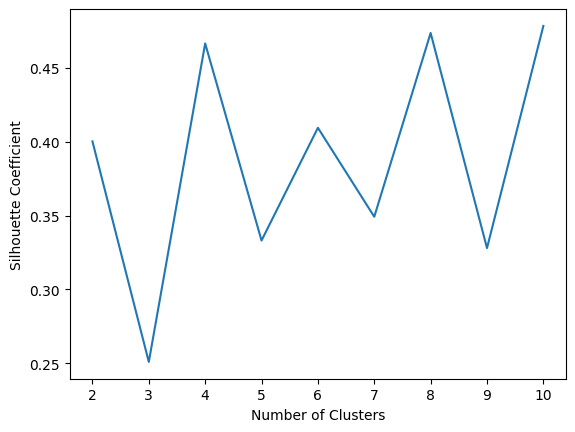

In [160]:
silhouette_coefficients = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, n_init="auto")
  kmeans.fit(data)
  score = silhouette_score(data, kmeans.labels_)
  silhouette_coefficients.append(score)

plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

This method seems to suggest 8 clusters. However, after consideration of several options, it looks like 7 is the best number, as the following plot shows. The axes have been relabelled to show the actual numbers and make it more comprehensible. Also a legend of clusters has been added.

In [200]:
kmeans = KMeans(n_clusters=7, n_init="auto")
kmeans.fit(data)
label = kmeans.fit_predict(normalized_data)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18884\403655041.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18884\403655041.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels)


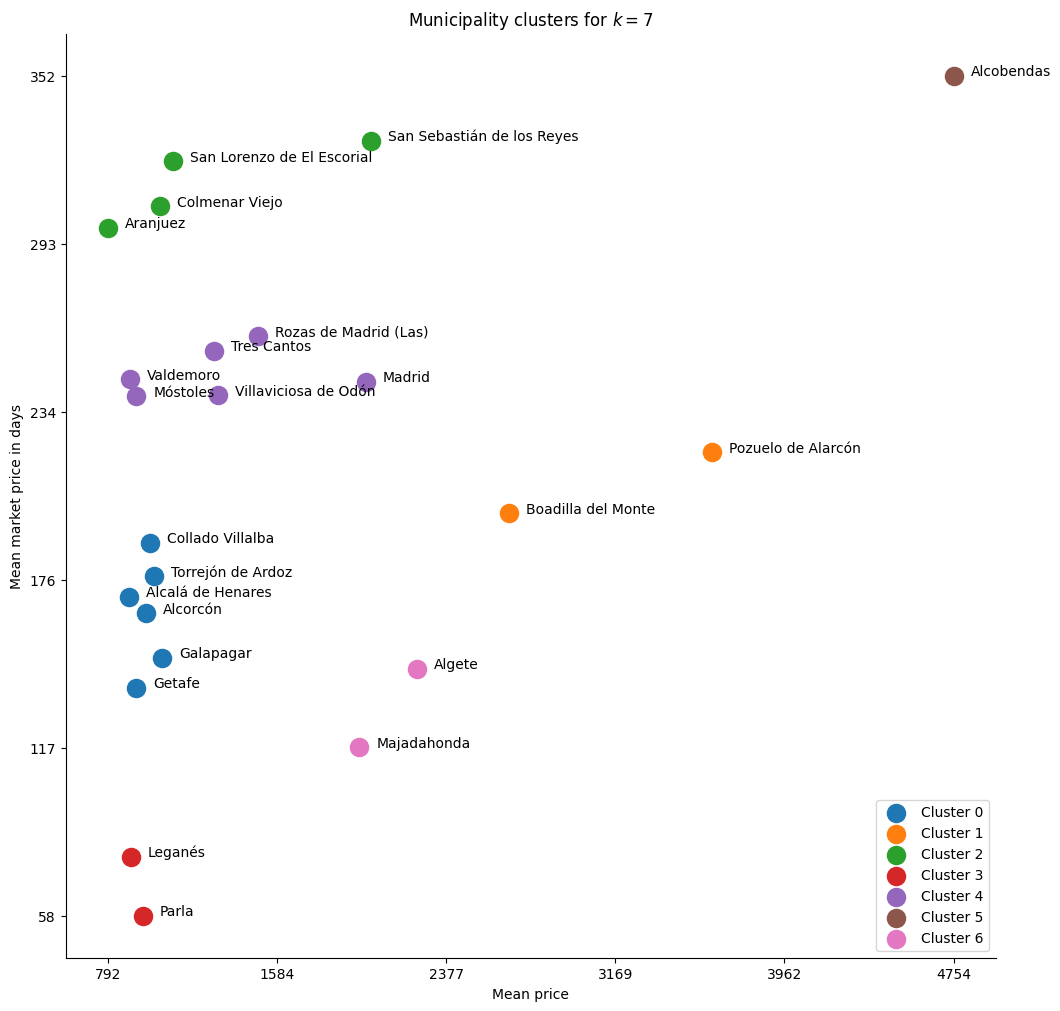

In [248]:
x = normalized_data["Mean_price"]
y = normalized_data["Mean_market_time"]
fig, ax = plt.subplots(figsize = (12,12))

normalized_data["label"] = label

for l in np.unique(label):
  ax.scatter(normalized_data[normalized_data["label"] == l]["Mean_price"],normalized_data[normalized_data["label"] == l]["Mean_market_time"], label = F"Cluster {l}", s= 170)
for i,text in enumerate(normalized_data.index):
  ax.annotate(text, (x[i]+0.02, y[i]))
ax.legend()
ax.spines[['right', 'top']].set_visible(False)
x_space = (grouped_data["Mean_price"].max()-grouped_data["Mean_price"].min())/5
y_space = (grouped_data["Mean_market_time"].max()-grouped_data["Mean_market_time"].min())/5
x_labels = [int(n*x_space) for n in range(7)]
y_labels = [int(n*y_space) for n in range(7)]
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)
ax.set_xlabel("Mean price")
ax.set_ylabel("Mean market price in days")
ax.set_title("Municipality clusters for $k=7$")

plt.show()
